# Project 5 — Traffic & Dirty Air Impact on Undercut Strategy

This notebook extends the undercut/overcut simulator by introducing
traffic and dirty air effects after pit stops.

The objective is to quantify when an undercut fails due to rejoining
behind slower cars, despite having fresher tyres.

This mirrors real Formula 1 strategy limitations beyond pure lap time.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("default")
sns.set_context("talk")
# Simulation window
current_lap = 25
analysis_window = 10
planned_pit_lap = 30

# Pit & tyre
pit_loss = 22.5
outlap_penalty = 1.2
base_lap_time = 90.0
degradation_per_lap = 0.15

# Traffic parameters
traffic_lap_loss = 0.8   # loss per lap behind slower car
traffic_duration = 3     # laps stuck in traffic
def degraded_lap_time(lap, stint_start):
    tyre_age = lap - stint_start
    return base_lap_time + degradation_per_lap * tyre_age

def fresh_lap_time(lap, stint_start):
    tyre_age = lap - stint_start
    return base_lap_time + 0.05 * tyre_age
def simulate_strategy_with_traffic(pit_lap, traffic=True):
    total_time = 0
    lap_times = []
    stint_start = current_lap

    for lap in range(current_lap, current_lap + analysis_window):

        if lap < pit_lap:
            lap_time = degraded_lap_time(lap, stint_start)

        elif lap == pit_lap:
            lap_time = pit_loss + outlap_penalty
            stint_start = lap

        else:
            lap_time = fresh_lap_time(lap, stint_start)

            # Apply traffic penalty after pit
            if traffic and lap < pit_lap + traffic_duration:
                lap_time += traffic_lap_loss

        lap_times.append(lap_time)
        total_time += lap_time

    return total_time, lap_times
baseline_time, _ = simulate_strategy_with_traffic(planned_pit_lap, traffic=False)

undercut_clean, _ = simulate_strategy_with_traffic(planned_pit_lap - 1, traffic=False)
undercut_traffic, _ = simulate_strategy_with_traffic(planned_pit_lap - 1, traffic=True)

comparison = pd.DataFrame({
    "Scenario": ["Baseline", "Undercut (Clean Air)", "Undercut (Traffic)"],
    "Total Time": [baseline_time, undercut_clean, undercut_traffic]
})

comparison["Delta vs Baseline (s)"] = comparison["Total Time"] - baseline_time
comparison


,Scenario,Total Time,Delta vs Baseline (s)
0,Baseline,835.70,0.00
1,Undercut (Clean Air),835.35,-0.35
2,Undercut (Traffic),836.95,1.25


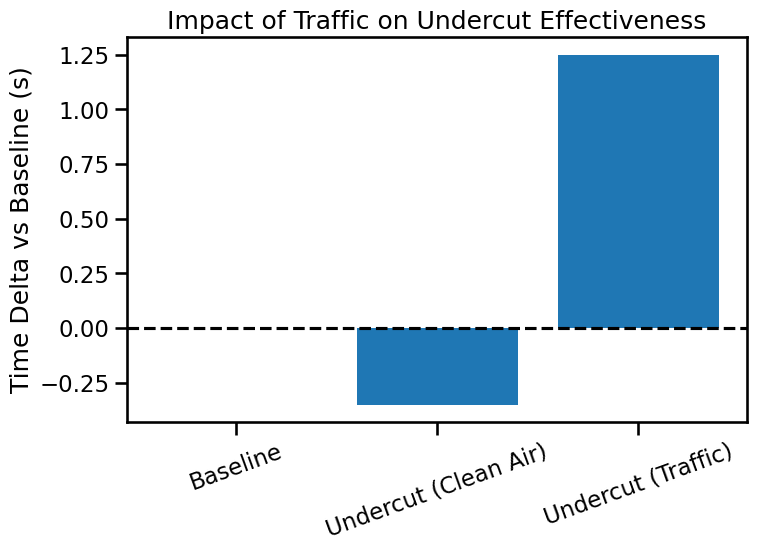

In [2]:
plt.figure(figsize=(8,5))

plt.bar(
    comparison["Scenario"],
    comparison["Delta vs Baseline (s)"]
)

plt.axhline(0, color="black", linestyle="--")
plt.ylabel("Time Delta vs Baseline (s)")
plt.title("Impact of Traffic on Undercut Effectiveness")
plt.xticks(rotation=20)

plt.show()


In [3]:
traffic_durations = range(0, 6)
delta_results = []

for duration in traffic_durations:
    traffic_duration = duration  # override

    total_time, _ = simulate_strategy_with_traffic(
        planned_pit_lap - 1,
        traffic=True
    )

    delta_results.append(total_time - baseline_time)

traffic_df = pd.DataFrame({
    "Traffic Duration (laps)": traffic_durations,
    "Delta vs Baseline (s)": delta_results
})

traffic_df


,Traffic Duration (laps),Delta vs Baseline (s)
0,0,-0.35
1,1,-0.35
2,2,0.45
3,3,1.25
4,4,2.05
5,5,2.85


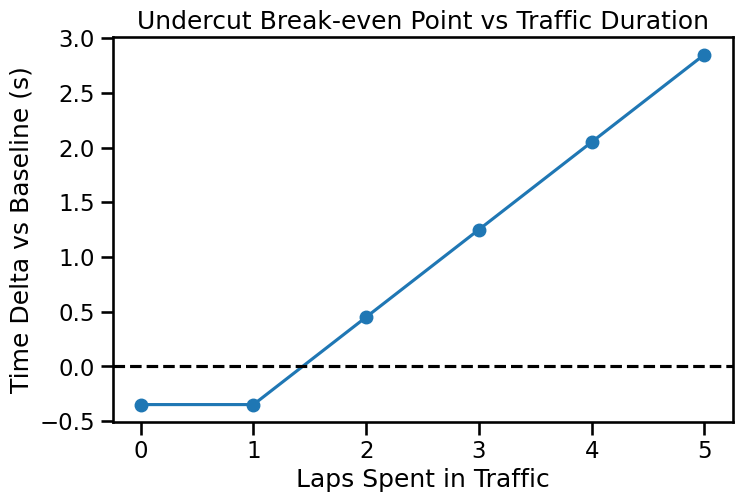

In [4]:
plt.figure(figsize=(8,5))

plt.plot(
    traffic_df["Traffic Duration (laps)"],
    traffic_df["Delta vs Baseline (s)"],
    marker="o"
)

plt.axhline(0, linestyle="--", color="black")
plt.xlabel("Laps Spent in Traffic")
plt.ylabel("Time Delta vs Baseline (s)")
plt.title("Undercut Break-even Point vs Traffic Duration")

plt.show()


In [5]:
traffic_probabilities = np.linspace(0, 1, 11)

delta_clean = undercut_clean - baseline_time
delta_traffic = undercut_traffic - baseline_time

ev_results = []

for p in traffic_probabilities:
    ev = p * delta_traffic + (1 - p) * delta_clean
    ev_results.append(ev)

ev_df = pd.DataFrame({
    "Traffic Probability": traffic_probabilities,
    "Expected Delta vs Baseline (s)": ev_results
})

ev_df


,Traffic Probability,Expected Delta vs Baseline (s)
0,0.0,-0.35
1,0.1,-0.19
2,0.2,-0.03
3,0.3,0.13
4,0.4,0.29
5,0.5,0.45
6,0.6,0.61
7,0.7,0.77
8,0.8,0.93
9,0.9,1.09


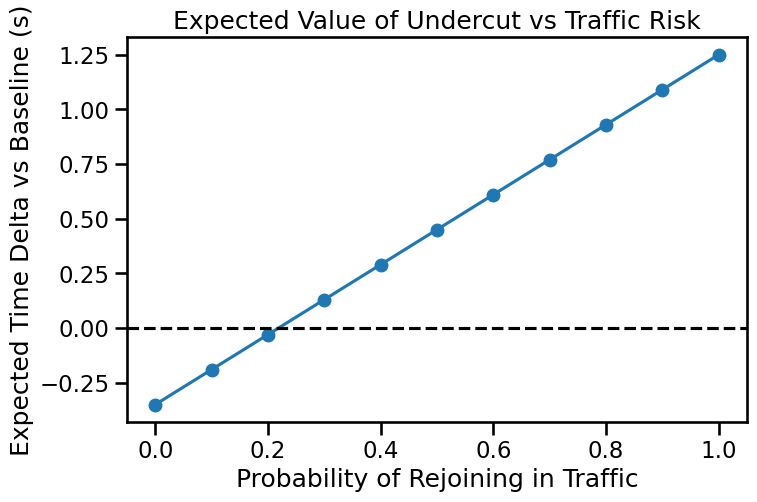

In [6]:
plt.figure(figsize=(8,5))

plt.plot(
    ev_df["Traffic Probability"],
    ev_df["Expected Delta vs Baseline (s)"],
    marker="o"
)

plt.axhline(0, linestyle="--", color="black")
plt.xlabel("Probability of Rejoining in Traffic")
plt.ylabel("Expected Time Delta vs Baseline (s)")
plt.title("Expected Value of Undercut vs Traffic Risk")

plt.show()


## Strategy Interpretation

Introducing traffic effects fundamentally changes the evaluation of
undercut strategies.

While an undercut provides a clear advantage in clean air, the results
show that even short periods spent in traffic can negate or reverse
this gain. Break-even analysis indicates that an undercut becomes
unfavorable after approximately two laps stuck behind slower cars.

Extending the model to a probabilistic framework reveals that undercuts
are only justified when the probability of rejoining in traffic is low.
Beyond roughly a 20–25% traffic risk, the expected value of the undercut
turns negative, making the baseline strategy the safer choice.

These findings illustrate why Formula 1 strategy decisions cannot rely
on idealized lap-time models alone. Effective pit timing requires
balancing potential pace gains against traffic risk and uncertainty,
favoring conservative decisions when track position is volatile.
